In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [40]:
now = datetime.now()

# Calculez le début de la semaine (lundi)
week_start = (now - timedelta(days=now.weekday())).strftime('%d/%m')

# Calculez la fin de la semaine (dimanche)
week_end = (now + timedelta(days=(6 - now.weekday()))).strftime('%d/%m')

# 

# 

# CHARGEMENT DES DONNEES

In [3]:
df_disruption = pd.read_csv("TGV_TER_perturbation.csv")

df_vehicle = pd.read_csv("TGV_TER_trajet_vehicules.csv")

df_lines = pd.read_csv("TGV_TER_lines_info.csv")

df_past = pd.read_csv('Resultats_rapport.csv')

# 

# 

# TRANSFORMATION DES DONNEES

In [4]:
df_disruption['disruption_start'] = pd.to_datetime(df_disruption['disruption_start'], format='%H:%M:%S')
df_disruption['disruption_end'] = pd.to_datetime(df_disruption['disruption_end'], format='%H:%M:%S')

df_disruption['duration_disruption'] = df_disruption['disruption_end'] - df_disruption['disruption_start']
df_disruption['cause_delay'] = df_disruption['cause_delay'].fillna('Non connu')

In [5]:
# Malveillance
incivilite = [
    "Acte de vandalisme",
    "Présence d'un bagage abandonné",
    "Présence d'individus sur les voies",
    "Incendie aux abords de la voie",
    "Déclenchement du signal d'alarme",
    "Intervention des forces de l'ordre"
]
# Problèmes techniques et matériel
problemes_techniques = [
    "Défaillance de matériel",
    "Panne de signalisation",
    "Panne d'un passage à niveau",
    "Panne d'un aiguillage",
    "Défaut d'alimentation électrique",
    "Indisponibilité d'un matériel",
    "Dérangement d'une installation en gare",
    "Modification de matériel"
]
# Conditions opérationnelles
conditions_operationnelles = [
    "Régulation du trafic",
    "Réutilisation d'un train",
    "Difficultés lors de la préparation du train",
    "Prise en charge de clients en correspondance",
    "Conditions de départ non réunies",
    "Mise à quai tardive en gare origine",
    "Arrêt exceptionnel en gare",
    "Saturation des voies en gare",
    "Confirmation tardive de la voie",
    "Erreur d'itinéraire"
]    
# Conditions externes
conditions_externes = [
    "Travaux sur les voies",
    "Obstacle sur la voie",
    "Incident de circulation",
    "Incident sur un réseau ferré étranger",
    "Accident de personne",
    "Conditions météorologiques",
    "Présence d'animaux sur la voie"
]

assistance_passagers = [
    "Assistance à un voyageur malade à bord",
    "Assistance à un voyageur",
    "Affluence de voyageurs entraînant un arrêt prolongé"
]

df_disruption['group_delay'] = df_disruption['cause_delay'].apply(lambda x: 'incivilite' if x in incivilite 
                                                                 else ('problemes techniques' if x in problemes_techniques
                                                                 else ('conditions operationnelles' if x in conditions_operationnelles
                                                                 else ('conditions externes' if x in conditions_externes
                                                                 else ('assistance passagers' if x in assistance_passagers
                                                                 else x)))))

In [6]:
df_disruption_unique = df_disruption.drop_duplicates(['id_disruption','vehicle_id'])

In [7]:
df_merge_inter = pd.merge(df_vehicle, df_disruption.drop(['data_date','train_type'],axis=1), on=['vehicle_id','id_disruption'], how='left')
df_merge = pd.merge(df_merge_inter, df_lines.drop('train_type', axis=1), on='route_id', how='left')
df_merge = df_merge[~df_merge.duplicated(subset=['vehicle_id'], keep='first')]

# 

# 

# ANALYSE GENERALE DES PERTURBATIONS

### NOMBRE DE PERTURBATION SUR LA SEMAINE --> Réduire l'apparition des perturbations

In [8]:
nb_disruption = df_vehicle['id_disruption'].nunique()
print(f"nombre de perturbation : {nb_disruption}")

nb_disruption_past = df_past['nb_disruption'][len(df_past)-1]
comparaison = "de plus" if nb_disruption_past < nb_disruption else "de moins"
print(f"C'est {abs(nb_disruption_past - nb_disruption)} {comparaison} que la semaine passée")

nombre de perturbation : 5553
C'est 1060 de plus que la semaine passée


In [9]:
nb_vehicle_journeys = df_vehicle['vehicle_id'].nunique()
print(f"nombre de trajet sur la semaine du {week_start} au {week_end} : {nb_vehicle_journeys}")

nombre de trajet sur la semaine du 20/05 au 26/05 : 46607


In [10]:
per_disrupted = nb_disruption/nb_vehicle_journeys*100
print(f"pourcentage de trajet pertubé sur la semaine du {week_start} au {week_end} : {round(per_disrupted,2)}%")

per_disrupted_past = df_past['per_disrupted'][len(df_past)-1]
comparaison = ["de plus", "augmentation"] if per_disrupted_past < per_disrupted else ["de moins", 'diminution']
print(f"C'est {abs(per_disrupted_past - per_disrupted):.2f}% {comparaison[0]} que la semaine passée. Soit une {comparaison[1]} de {abs((per_disrupted_past-per_disrupted)/per_disrupted*100):.2f}%")

pourcentage de trajet pertubé sur la semaine du 20/05 au 26/05 : 11.91%
C'est 0.05% de moins que la semaine passée. Soit une diminution de 0.40%


In [11]:
nb_disruption_daily = df_vehicle.groupby('data_date')['id_disruption'].nunique()
nb_vehicle_journeys_daily = df_vehicle.groupby('data_date')['vehicle_id'].nunique()

per_disrupted_daily = nb_disruption_daily/nb_vehicle_journeys_daily*100

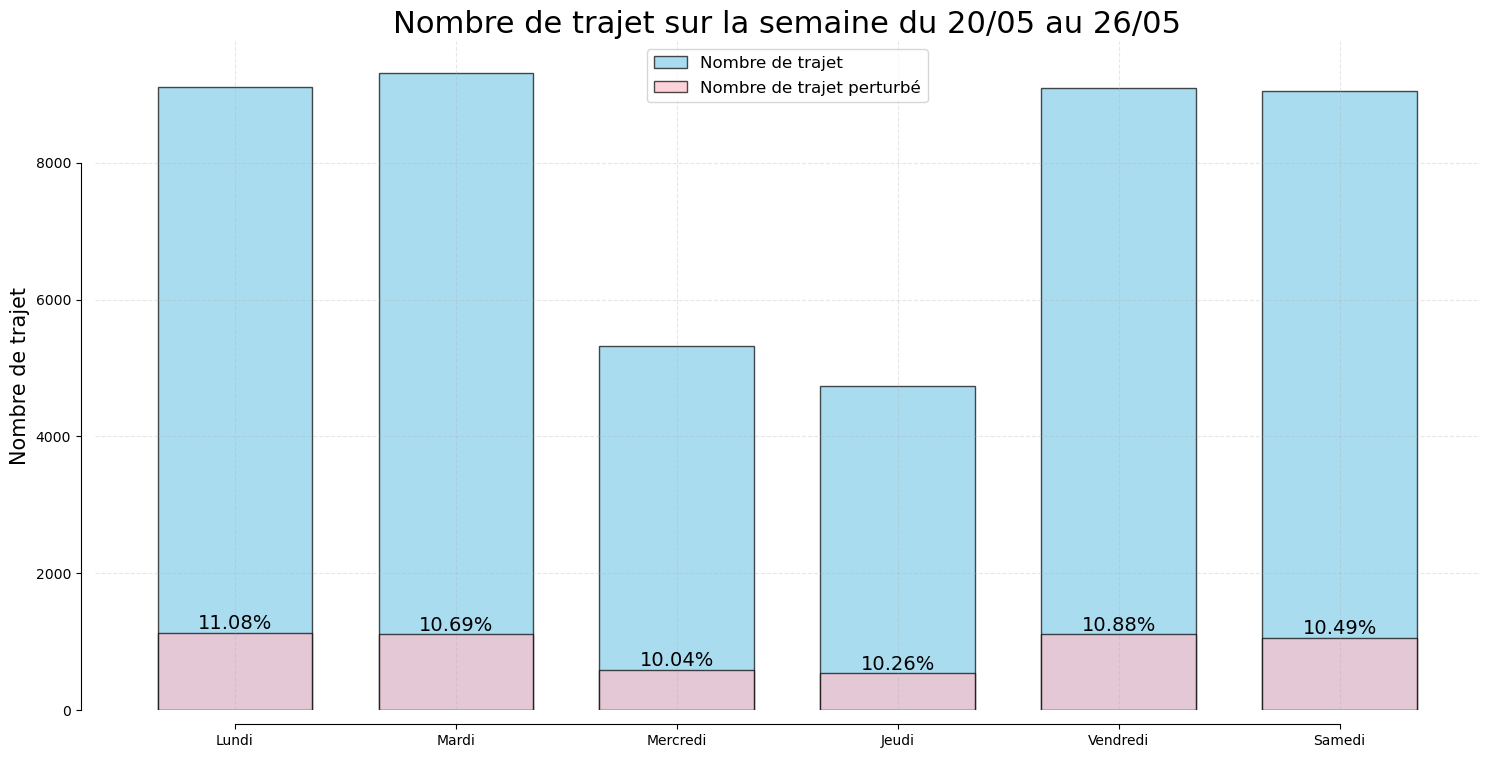

In [12]:
days_name = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi']

plt.figure(figsize=(15, 8))
plt.bar(nb_vehicle_journeys_daily.index, nb_vehicle_journeys_daily.values, color='skyblue', edgecolor='black', width=0.7, alpha=0.7, label= 'Nombre de trajet')
plt.bar(nb_disruption_daily.index, nb_disruption_daily.values, color='pink', edgecolor='black', width=0.7, alpha=0.7, label= 'Nombre de trajet perturbé')

for i in range(len(nb_vehicle_journeys_daily)):
    plt.text(nb_vehicle_journeys_daily.index[i], nb_disruption_daily.values[i], f'{nb_disruption_daily.values[i]/(nb_vehicle_journeys_daily.values[i] + nb_disruption_daily.values[i])*100:.2f}%', ha='center', va='bottom', fontsize=14)
    
plt.title(f'Nombre de trajet sur la semaine du {week_start} au {week_end}', fontsize=22)
plt.ylabel('Nombre de trajet', fontsize=15)
plt.xticks(nb_disruption_daily.index,days_name , rotation=30, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
sns.despine(offset=10, trim=True)

plt.legend(fontsize='12')


plt.show()

# 

###  TEMPS MOYEN DES PERTURBATIONS --> Si la perturbation est bien gérer

In [13]:
mean_time_disruption_minutes = int((df_disruption['duration_disruption'].dt.total_seconds()/(60)).mean())

print(f"Le temps moyen des perturbations sur la semaine du {week_start} au {week_end} a été de : {mean_time_disruption_minutes//60} heure et {mean_time_disruption_minutes%60} minutes")

mean_time_disruption_minutes_past = df_past['mean_time_disruption_minutes'][len(df_past)-1]
comparaison = ["de plus", "augmentation"] if mean_time_disruption_minutes_past < mean_time_disruption_minutes else ["de moins", 'diminution']
print(f"C'est {abs(mean_time_disruption_minutes_past - mean_time_disruption_minutes)} minutes {comparaison[0]} que la semaine passée. Ceci représente une {comparaison[1]} de {abs((mean_time_disruption_minutes_past-mean_time_disruption_minutes)/mean_time_disruption_minutes*100):.2f}%")

Le temps moyen des perturbations sur la semaine du 20/05 au 26/05 a été de : 1 heure et 46 minutes
C'est 1 minutes de plus que la semaine passée. Ceci représente une augmentation de 0.94%


In [14]:
mean_time_disruption_minutes_daily = round(df_disruption.groupby('data_date')['duration_disruption'].mean().dt.total_seconds()/60)

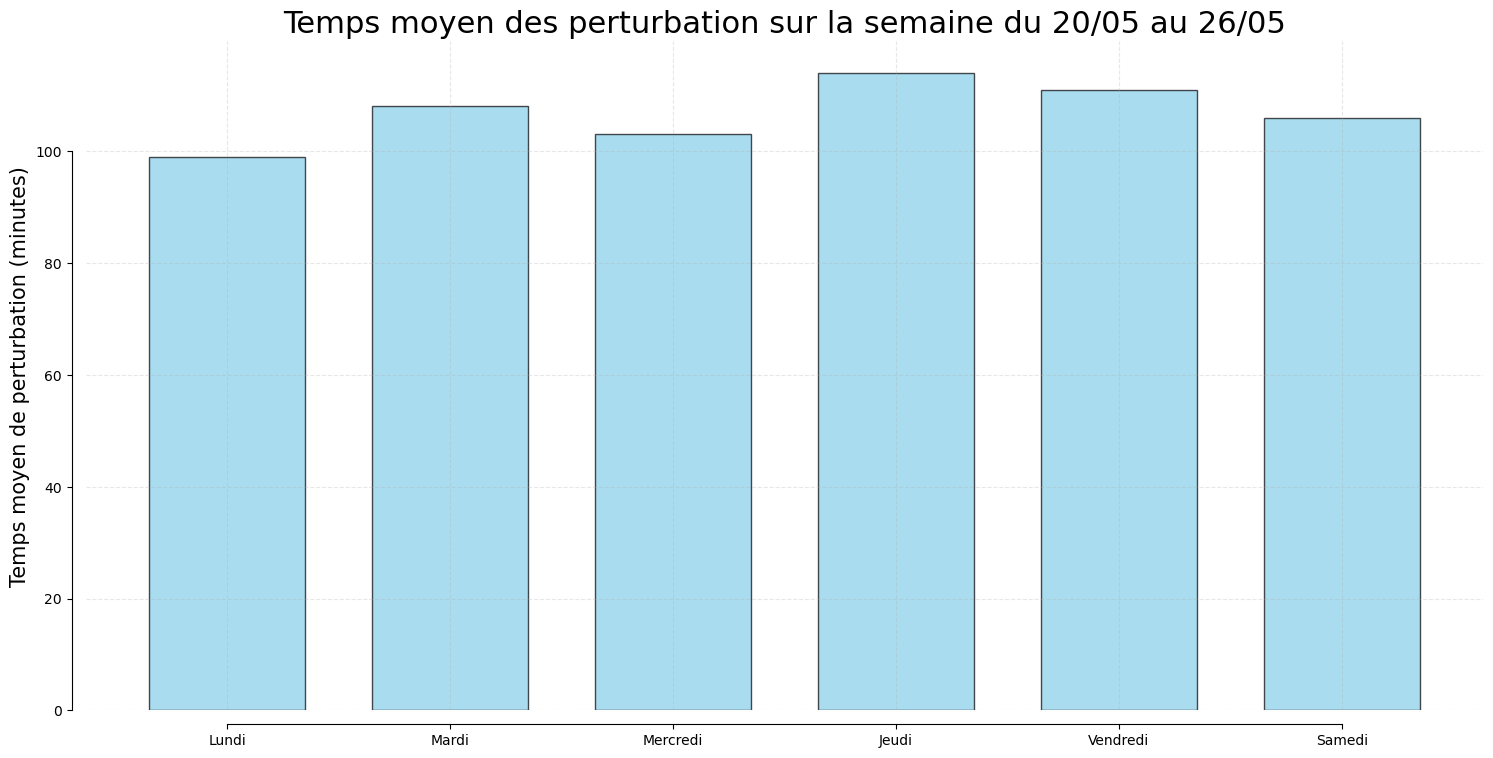

In [15]:
# eventuellement le passé en plot avec le chiffre sur chaque noeud
plt.figure(figsize=(15, 8))
plt.bar(mean_time_disruption_minutes_daily.index, mean_time_disruption_minutes_daily.values, color='skyblue', edgecolor='black', width=0.7, alpha=0.7)

plt.title(f'Temps moyen des perturbation sur la semaine du {week_start} au {week_end}', fontsize=22)
plt.ylabel('Temps moyen de perturbation (minutes)', fontsize=15)
plt.xticks(nb_disruption_daily.index, days_name, rotation=30, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
sns.despine(offset=10, trim=True)

plt.show()

# 

### RETARD CAUSE PAR LES PERTURBATIONS --> Reduire l'impact des perturbations

In [16]:
total_delay = int(df_disruption['arrival_delay'].sum()/60)

print(f"Ces perturbations ont causé durant  la semaine du {week_start} au {week_end}: {total_delay} heures de retard cummulé sur l'ensemble du réseau \n")
print(f"Ceci represente une moyenne d'environ {round(total_delay/nb_disruption*60)} minutes de retard cummulé sur l'esemble du réseau par perturbation enregistré")

Ces perturbations ont causé durant  la semaine du 20/05 au 26/05: 5242 heures de retard cummulé sur l'ensemble du réseau 

Ceci represente une moyenne d'environ 57 minutes de retard cummulé sur l'esemble du réseau par perturbation enregistré


In [17]:
total_delay_daily = round(df_disruption.groupby('data_date')['arrival_delay'].sum()/60)

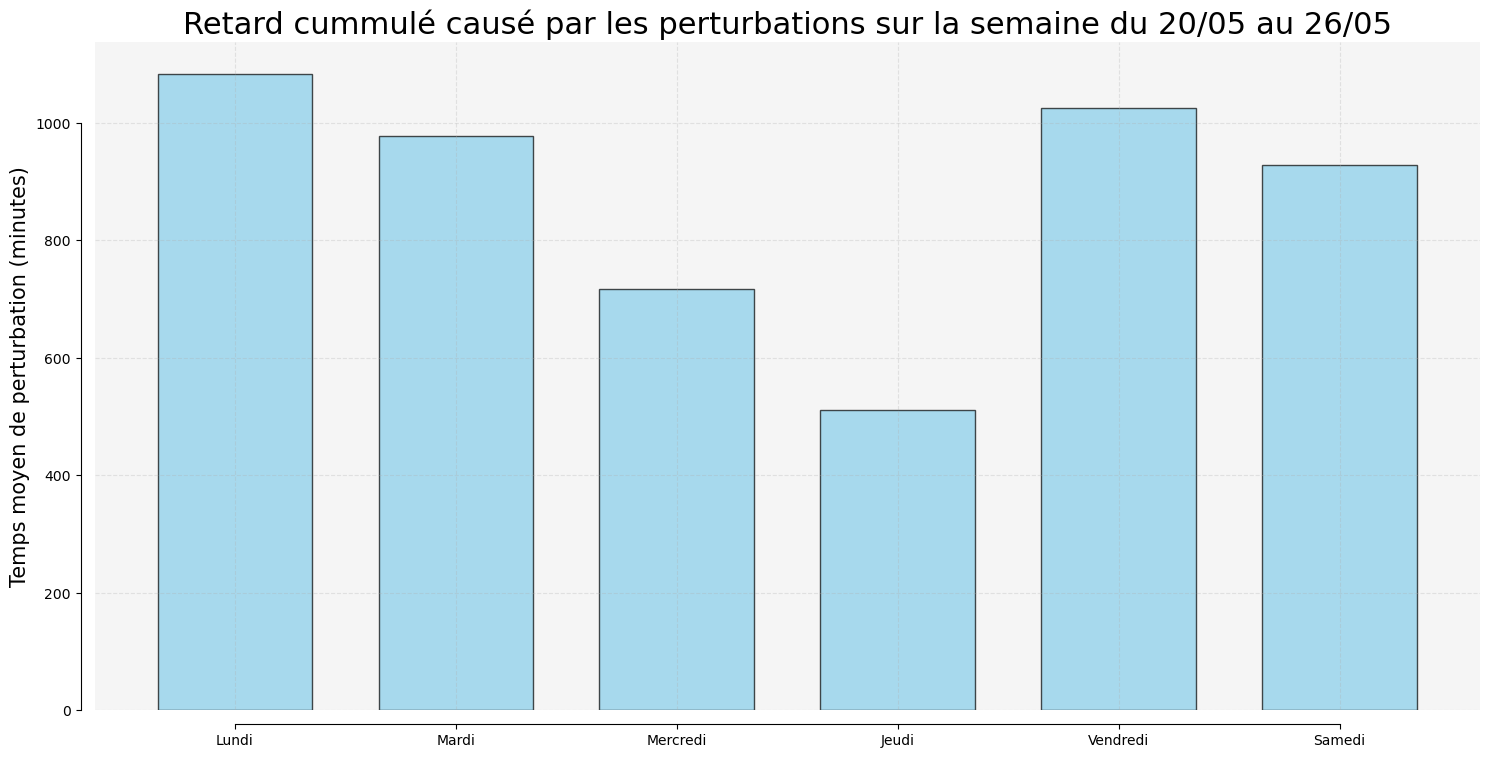

In [18]:
# eventuellement le passé en plot avec le chiffre (ecrit correctement) sur chaque noeud
plt.figure(figsize=(15, 8))
plt.bar(total_delay_daily.index, total_delay_daily.values, color='skyblue', edgecolor='black', width=0.7, alpha=0.7)

plt.title(f'Retard cummulé causé par les perturbations sur la semaine du {week_start} au {week_end}', fontsize=22)
plt.ylabel('Temps moyen de perturbation (minutes)', fontsize=15)
plt.xticks(nb_disruption_daily.index, days_name, rotation=30, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True, linestyle='--', alpha=0.3)
plt.gca().set_facecolor('whitesmoke')

plt.tight_layout()
sns.despine(offset=10, trim=True)

plt.show()

# 

# 

# ANALYSE DETAILLEE DES PERTURBATION

### NOMBRE DE PERTURBATION PAR RESEAU ET RETARD MOYEN

In [19]:
# Calcul du nombre de trajets de chaque réseau 
vehicle_by_network = df_merge.groupby('network_name')['vehicle_id'].count()

# Calcul du nombre de trajets perturbé par réseau
disrupted_vehicle_by_network = df_merge[df_merge['id_disruption'].notna()].groupby('network_name')['vehicle_id'].count()

# Gestion du cas (pas si rare que ca) où aucun trajet du réseau n'a été perturbé
for name in vehicle_by_network.index:
    if not(name in disrupted_vehicle_by_network.index):
        disrupted_vehicle_by_network[name] = 0

In [20]:
# Calcul du pourcentage de perturbation pour chaque réseau
per_disrupted_vehicle_by_network = (disrupted_vehicle_by_network/vehicle_by_network *100).where(disrupted_vehicle_by_network >= 1, 0).sort_values(ascending=True)
#en faire un tableau


# Calcul du retard total (à l'arrivée des gares) pour chaque réseau
total_delay_by_network = df_merge.groupby('network_name')['arrival_delay'].sum()

# Calcul du retard moyen par train pour chaque réseau
avg_delay_by_network = total_delay_by_network/vehicle_by_network

for i in range(len(disrupted_vehicle_by_network)):
    if not(disrupted_vehicle_by_network.index[i] in total_delay_by_network.index) : 
        avg_delay_by_network[i] = 0
        
# Conversion en string indicant les retards moyens en seconde
for i in range(len(avg_delay_by_network)):
    if avg_delay_by_network[i] != 0:
        avg_delay_by_network[i] = str(int(avg_delay_by_network[i]*60)) + " secondes" 
    else : 
        avg_delay_by_network[i] = "0 seconde"
# en faire un tableau

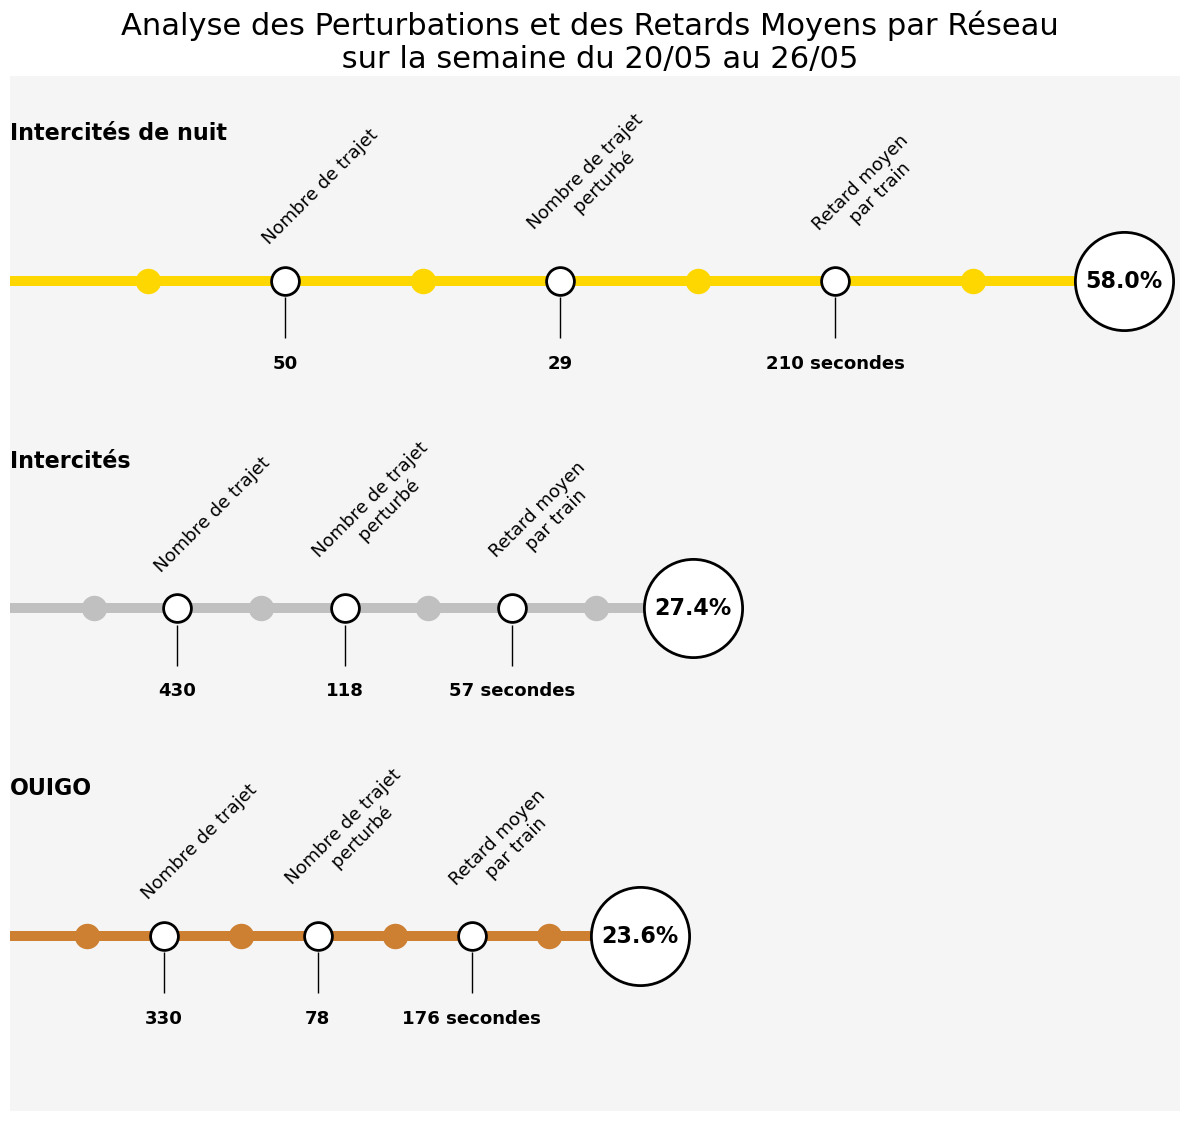

In [21]:
# Informations à placer sur le graphique
info = [vehicle_by_network, disrupted_vehicle_by_network, avg_delay_by_network]
info_name = ["Nombre de trajet", "Nombre de trajet \n perturbé", "Retard moyen \n par train"] 

# Filtrage des éléments désirés directement avec Pandas
per_disrupted_vehicle_by_network_part1 = per_disrupted_vehicle_by_network.iloc[9:]

# Création d'une nouvelle Series avec les transformations souhaitées
transformation = (per_disrupted_vehicle_by_network_part1 + 20) * 0.1

# Configuration initiale de la figure
fig, ax = plt.subplots(figsize=(12, 12))
colors = ["#CD7F32", "#C0C0C0", "#FFD700"]

# Création du diagramme à barres horizontales
bars = ax.barh(transformation.index, transformation, color=colors, height=0.03)

# Ajout du titre du graphique
ax.set_title(f'Analyse des Perturbations et des Retards Moyens par Réseau \n sur la semaine du {week_start} au {week_end}', fontsize=22)

# Calcul des positions pour les marqueurs
x_positions = transformation + 0.1

# Ajout de marqueurs blancs
ax.scatter(x_positions, transformation.index, facecolors='white', edgecolors='black', linewidths=2, s=5000)

# Définition des intervalles pour les éléments décoratifs
intervals_white = [2/8, 4/8, 6/8]
intervals_black = [1/8, 3/8, 5/8, 7/8]

# Boucle pour ajouter du texte et des décorations supplémentaires sur les barres
for j, (bar, new_x) in enumerate(zip(bars, x_positions)):
    y = bar.get_y() + bar.get_height() / 2
    
    # Ajout de texte pour le pourcentage
    ax.text(new_x, y, f'{bar.get_width()/0.1 - 20:.1f}%', ha='center', va='center', fontsize=16, fontweight='bold')
    
    # Ajouter le nom du réseau au-dessus de chaque barre
    ax.text(0, y + bar.get_height() + 0.4, per_disrupted_vehicle_by_network_part1.index[j], fontsize=16, fontweight='bold')
    
    # Ajout de cercles et de lignes avec du texte
    for i, interval in enumerate(intervals_white):
        circle_x = bar.get_width() * interval
        # Ajouter cercle blanc et ligne
        ax.scatter(circle_x, y, facecolors='white', edgecolors='black', linewidths=2, s=400)
        ax.vlines(circle_x, y - 0.05, y - 0.175, colors='black', linewidth=1)
        # Ajouter texte spécifique sous la ligne
        current_info_value = info[i][transformation.index[j]]
        ax.text(circle_x, y - 0.225, f'{current_info_value}', ha='center', va='top', fontsize=13, fontweight='bold')
        # Ajouter texte spécifique au-dessus du cercle
        ax.text(circle_x + 0.25, y + 0.1, info_name[i], ha='center', va='bottom', fontsize=13, rotation=45)
        
    # Ajout de cercles colorés pour les intervalles neutre
    for interval in intervals_black:
        circle_x = bar.get_width() * interval
        ax.scatter(circle_x, y, facecolors=colors[j], s=300)

# Configuration finale du graphique
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_facecolor('whitesmoke')
sns.despine(left=True, bottom=True, ax=ax, offset=10, trim=True)
plt.tight_layout()
ax.set_ylim(bottom=ax.get_ylim()[0] -0.25, top=ax.get_ylim()[1] +0.5)
plt.show()

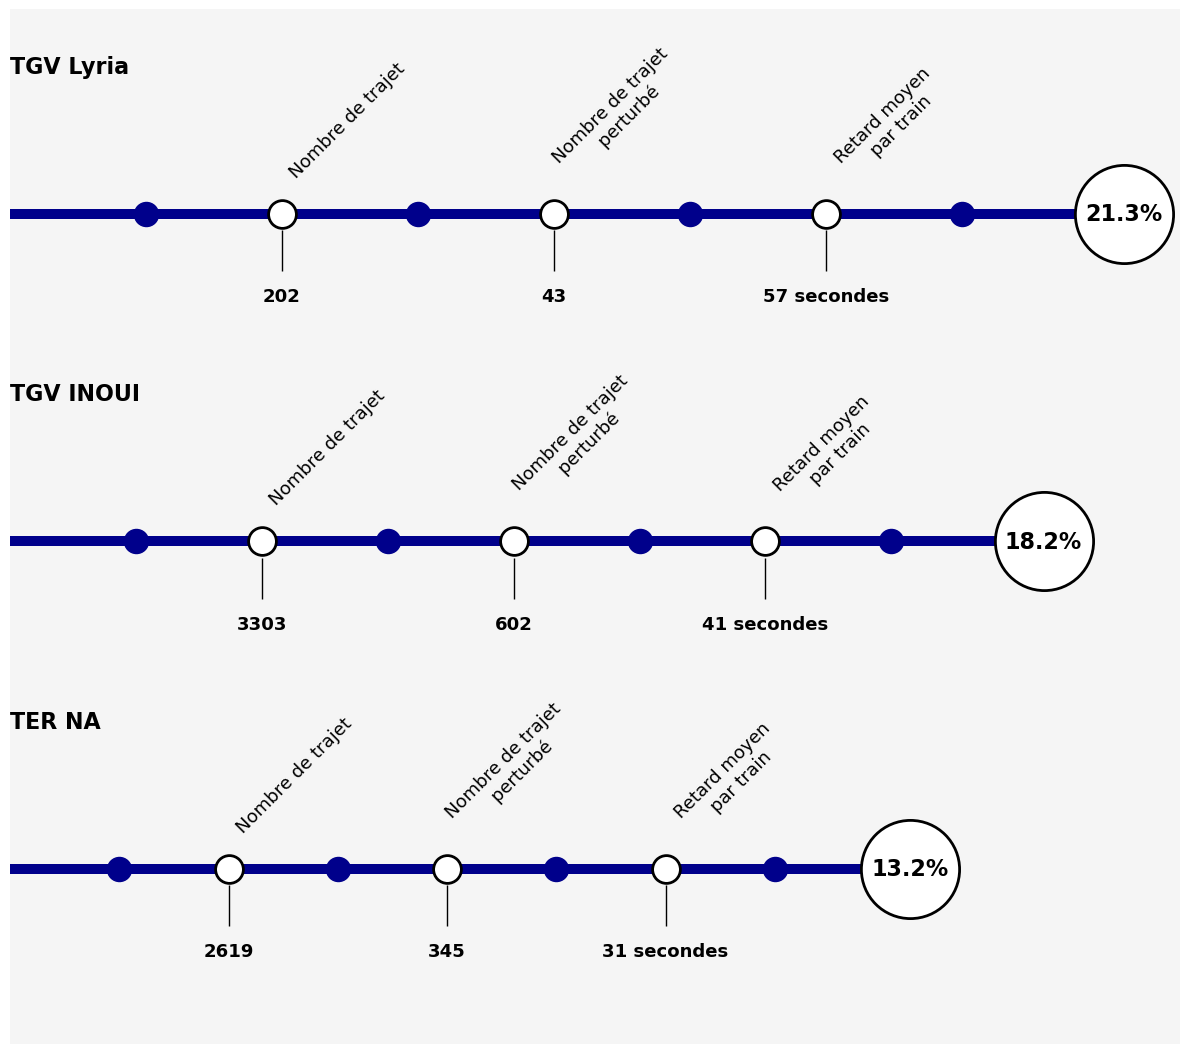

In [22]:
# Filtrage des éléments désirés directement avec Pandas
per_disrupted_vehicle_by_network_part1 = per_disrupted_vehicle_by_network.iloc[6:9]

# Création d'une nouvelle Series avec les transformations souhaitées
transformation = (per_disrupted_vehicle_by_network_part1 + 20) * 0.1

# Configuration initiale de la figure
fig, ax = plt.subplots(figsize=(12, 12))
colors = ["darkblue", "darkblue", "darkblue"]

# Création du diagramme à barres horizontales
bars = ax.barh(transformation.index, transformation, color=colors, height=0.03)

# Calcul des positions pour les marqueurs
x_positions = transformation + 0.1

# Ajout de marqueurs blancs
ax.scatter(x_positions, transformation.index, facecolors='white', edgecolors='black', linewidths=2, s=5000)

# Définition des intervalles pour les éléments décoratifs
intervals_white = [2/8, 4/8, 6/8]
intervals_black = [1/8, 3/8, 5/8, 7/8]

# Boucle pour ajouter du texte et des décorations supplémentaires sur les barres
for j, (bar, new_x) in enumerate(zip(bars, x_positions)):
    y = bar.get_y() + bar.get_height() / 2
    
    # Ajout de texte pour le pourcentage
    ax.text(new_x, y, f'{bar.get_width()/0.1 - 20:.1f}%', ha='center', va='center', fontsize=16, fontweight='bold')
    
    # Ajouter le nom du réseau au-dessus de chaque barre
    ax.text(0, y + bar.get_height() + 0.4, per_disrupted_vehicle_by_network_part1.index[j], fontsize=16, fontweight='bold')
    
    # Ajout de cercles et de lignes avec du texte
    for i, interval in enumerate(intervals_white):
        circle_x = bar.get_width() * interval
        # Ajouter cercle blanc et ligne
        ax.scatter(circle_x, y, facecolors='white', edgecolors='black', linewidths=2, s=400)
        ax.vlines(circle_x, y - 0.05, y - 0.175, colors='black', linewidth=1)
        # Ajouter texte spécifique sous la ligne
        current_info_value = info[i][transformation.index[j]]
        ax.text(circle_x, y - 0.225, f'{current_info_value}', ha='center', va='top', fontsize=13, fontweight='bold')
        # Ajouter texte spécifique au-dessus du cercle
        ax.text(circle_x + 0.25, y + 0.1, info_name[i], ha='center', va='bottom', fontsize=13, rotation=45)
        
    # Ajout de cercles colorés pour les intervalles neutre
    for interval in intervals_black:
        circle_x = bar.get_width() * interval
        ax.scatter(circle_x, y, facecolors=colors[j], s=300)

# Configuration finale du graphique
ax.set_title('', fontsize=22)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_facecolor('whitesmoke')
sns.despine(left=True, bottom=True, ax=ax, offset=10, trim=True)
plt.tight_layout()
ax.set_ylim(bottom=ax.get_ylim()[0] -0.25, top=ax.get_ylim()[1] +0.5)
plt.savefig("Perturbation_ligne_part2.png", dpi = 300)
plt.show()

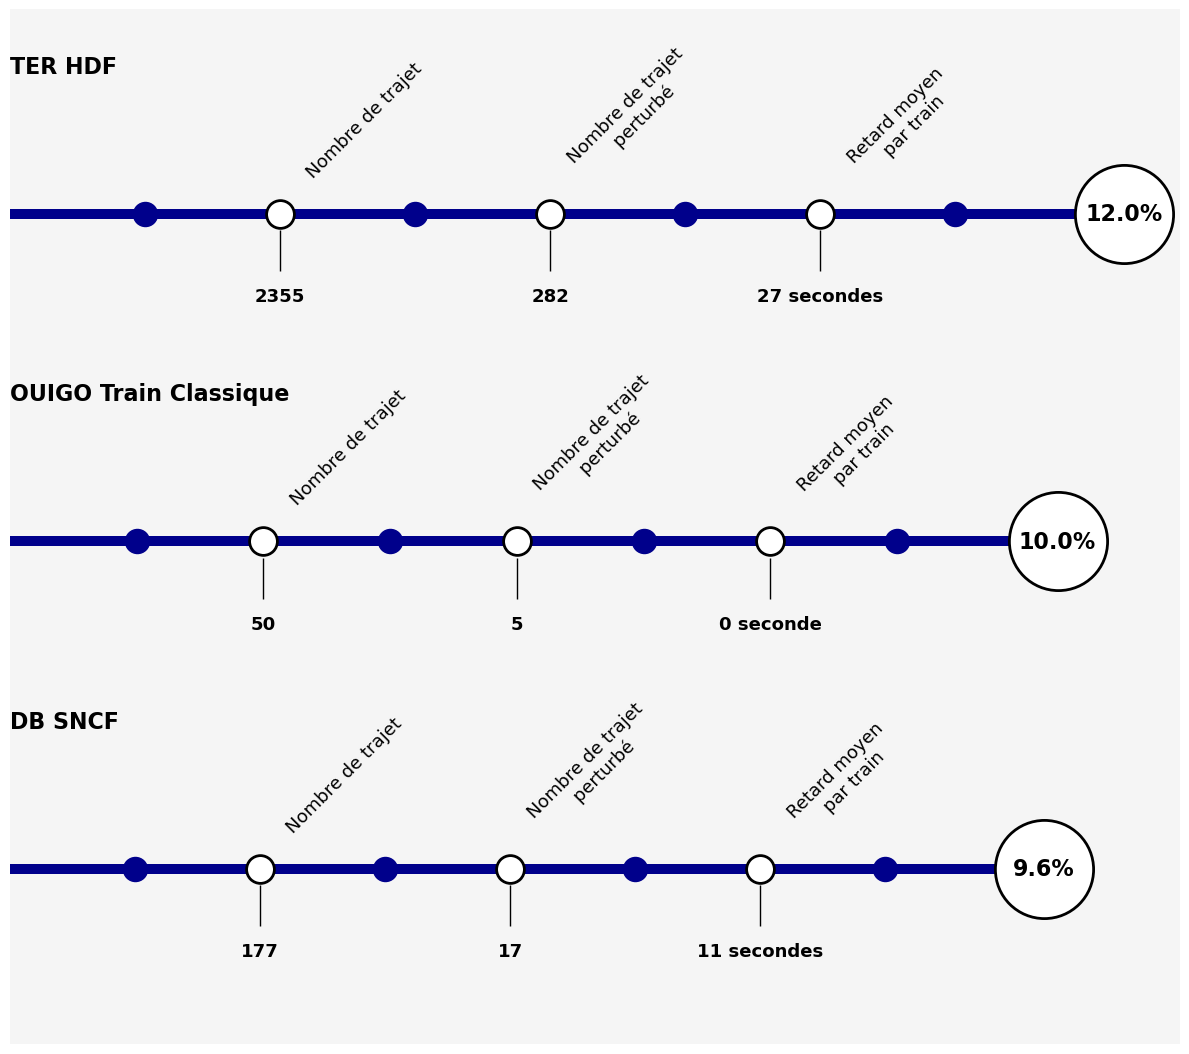

In [23]:
# Filtrage des éléments désirés directement avec Pandas
per_disrupted_vehicle_by_network_part1 = per_disrupted_vehicle_by_network.iloc[3:6]

# Création d'une nouvelle Series avec les transformations souhaitées
transformation = (per_disrupted_vehicle_by_network_part1 + 20) * 0.1

# Configuration initiale de la figure
fig, ax = plt.subplots(figsize=(12, 12))
colors = ["darkblue", "darkblue", "darkblue"]

# Création du diagramme à barres horizontales
bars = ax.barh(transformation.index, transformation, color=colors, height=0.03)

# Calcul des positions pour les marqueurs
x_positions = transformation + 0.1

# Ajout de marqueurs blancs
ax.scatter(x_positions, transformation.index, facecolors='white', edgecolors='black', linewidths=2, s=5000)

# Définition des intervalles pour les éléments décoratifs
intervals_white = [2/8, 4/8, 6/8]
intervals_black = [1/8, 3/8, 5/8, 7/8]

# Boucle pour ajouter du texte et des décorations supplémentaires sur les barres
for j, (bar, new_x) in enumerate(zip(bars, x_positions)):
    y = bar.get_y() + bar.get_height() / 2
    
    # Ajout de texte pour le pourcentage
    ax.text(new_x, y, f'{bar.get_width()/0.1 - 20:.1f}%', ha='center', va='center', fontsize=16, fontweight='bold')
    
    # Ajouter le nom du réseau au-dessus de chaque barre
    ax.text(0, y + bar.get_height() + 0.4, per_disrupted_vehicle_by_network_part1.index[j], fontsize=16, fontweight='bold')
    
    # Ajout de cercles et de lignes avec du texte
    for i, interval in enumerate(intervals_white):
        circle_x = bar.get_width() * interval
        # Ajouter cercle blanc et ligne
        ax.scatter(circle_x, y, facecolors='white', edgecolors='black', linewidths=2, s=400)
        ax.vlines(circle_x, y - 0.05, y - 0.175, colors='black', linewidth=1)
        # Ajouter texte spécifique sous la ligne
        current_info_value = info[i][transformation.index[j]]
        ax.text(circle_x, y - 0.225, f'{current_info_value}', ha='center', va='top', fontsize=13, fontweight='bold')
        # Ajouter texte spécifique au-dessus du cercle
        ax.text(circle_x + 0.25, y + 0.1, info_name[i], ha='center', va='bottom', fontsize=13, rotation=45)
        
    # Ajout de cercles colorés pour les intervalles neutre
    for interval in intervals_black:
        circle_x = bar.get_width() * interval
        ax.scatter(circle_x, y, facecolors=colors[j], s=300)

# Configuration finale du graphique
ax.set_title('', fontsize=22)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_facecolor('whitesmoke')
sns.despine(left=True, bottom=True, ax=ax, offset=10, trim=True)
plt.tight_layout()
ax.set_ylim(bottom=ax.get_ylim()[0] -0.25, top=ax.get_ylim()[1] +0.5)
plt.savefig("Perturbation_ligne_part3.png", dpi = 300)
plt.show()

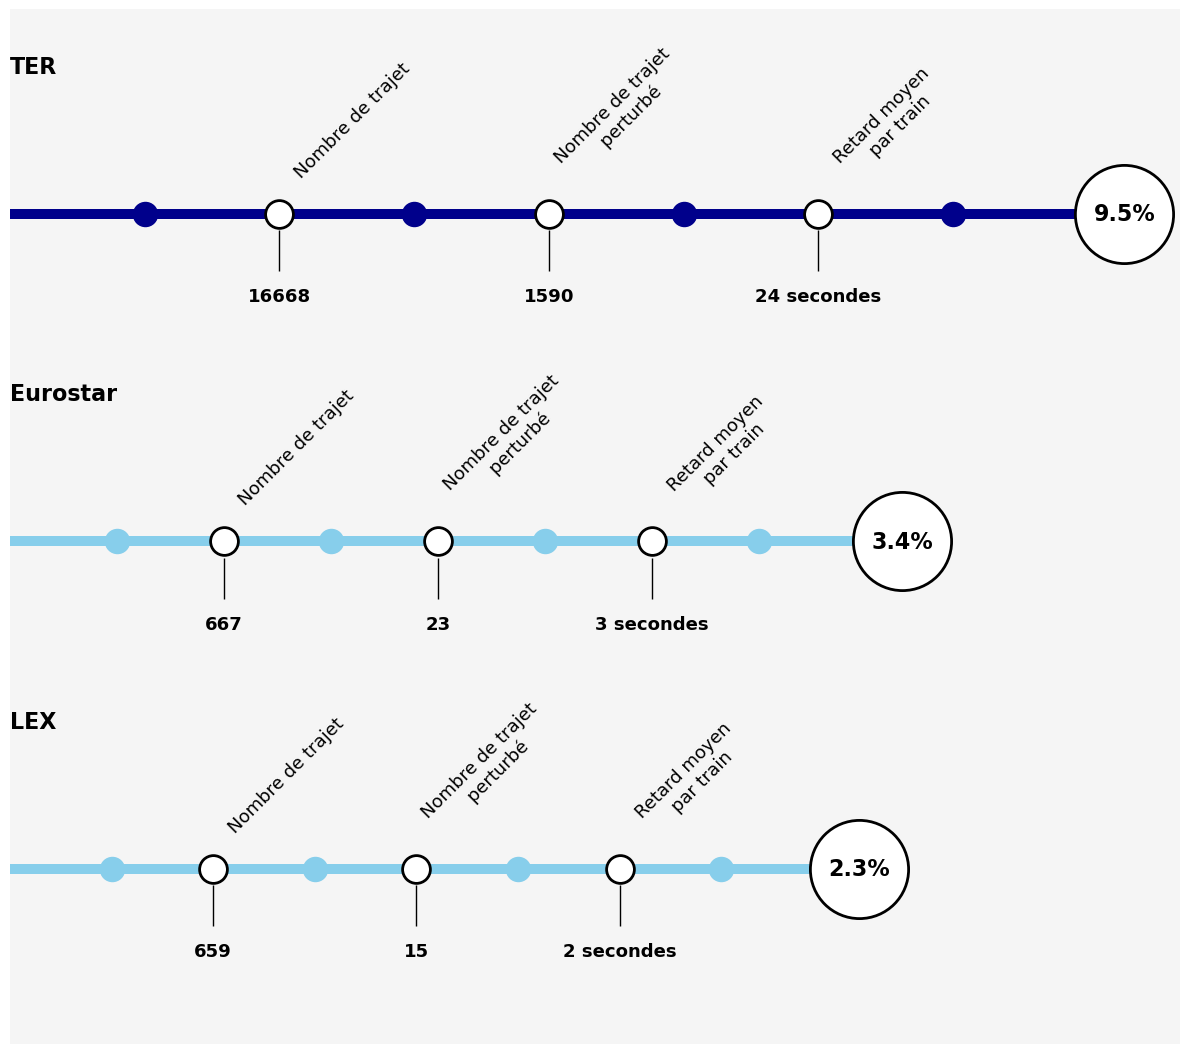

In [24]:
# Filtrage des éléments désirés directement avec Pandas
per_disrupted_vehicle_by_network_part1 = per_disrupted_vehicle_by_network.iloc[:3]

# Création d'une nouvelle Series avec les transformations souhaitées
transformation = (per_disrupted_vehicle_by_network_part1 + 20) * 0.1

# Configuration initiale de la figure
fig, ax = plt.subplots(figsize=(12, 12))
colors = ["skyblue", "skyblue", 'darkblue']

# Création du diagramme à barres horizontales
bars = ax.barh(transformation.index, transformation, color=colors, height=0.03)

# Calcul des positions pour les marqueurs
x_positions = transformation + 0.1

# Ajout de marqueurs blancs
ax.scatter(x_positions, transformation.index, facecolors='white', edgecolors='black', linewidths=2, s=5000)

# Définition des intervalles pour les éléments décoratifs
intervals_white = [2/8, 4/8, 6/8]
intervals_black = [1/8, 3/8, 5/8, 7/8]

# Boucle pour ajouter du texte et des décorations supplémentaires sur les barres
for j, (bar, new_x) in enumerate(zip(bars, x_positions)):
    y = bar.get_y() + bar.get_height() / 2
    
    # Ajout de texte pour le pourcentage
    ax.text(new_x, y, f'{bar.get_width()/0.1 - 20:.1f}%', ha='center', va='center', fontsize=16, fontweight='bold')
    
    # Ajouter le nom du réseau au-dessus de chaque barre
    ax.text(0, y + bar.get_height() + 0.4, per_disrupted_vehicle_by_network_part1.index[j], fontsize=16, fontweight='bold')
    
    # Ajout de cercles et de lignes avec du texte
    for i, interval in enumerate(intervals_white):
        circle_x = bar.get_width() * interval
        # Ajouter cercle blanc et ligne
        ax.scatter(circle_x, y, facecolors='white', edgecolors='black', linewidths=2, s=400)
        ax.vlines(circle_x, y - 0.05, y - 0.175, colors='black', linewidth=1)
        # Ajouter texte spécifique sous la ligne
        current_info_value = info[i][transformation.index[j]]
        ax.text(circle_x, y - 0.225, f'{current_info_value}', ha='center', va='top', fontsize=13, fontweight='bold')
        # Ajouter texte spécifique au-dessus du cercle
        ax.text(circle_x + 0.2, y + 0.1, info_name[i], ha='center', va='bottom', fontsize=13, rotation=45)
        
    # Ajout de cercles colorés pour les intervalles neutre
    for interval in intervals_black:
        circle_x = bar.get_width() * interval
        ax.scatter(circle_x, y, facecolors=colors[j], s=300)

# Configuration finale du graphique
ax.set_title('', fontsize=22)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_facecolor('whitesmoke')
sns.despine(left=True, bottom=True, ax=ax, offset=10, trim=True)
plt.tight_layout()
ax.set_ylim(bottom=ax.get_ylim()[0] -0.25, top=ax.get_ylim()[1] +0.5)
plt.savefig("Perturbation_ligne_part4.png", dpi = 300)
plt.show()

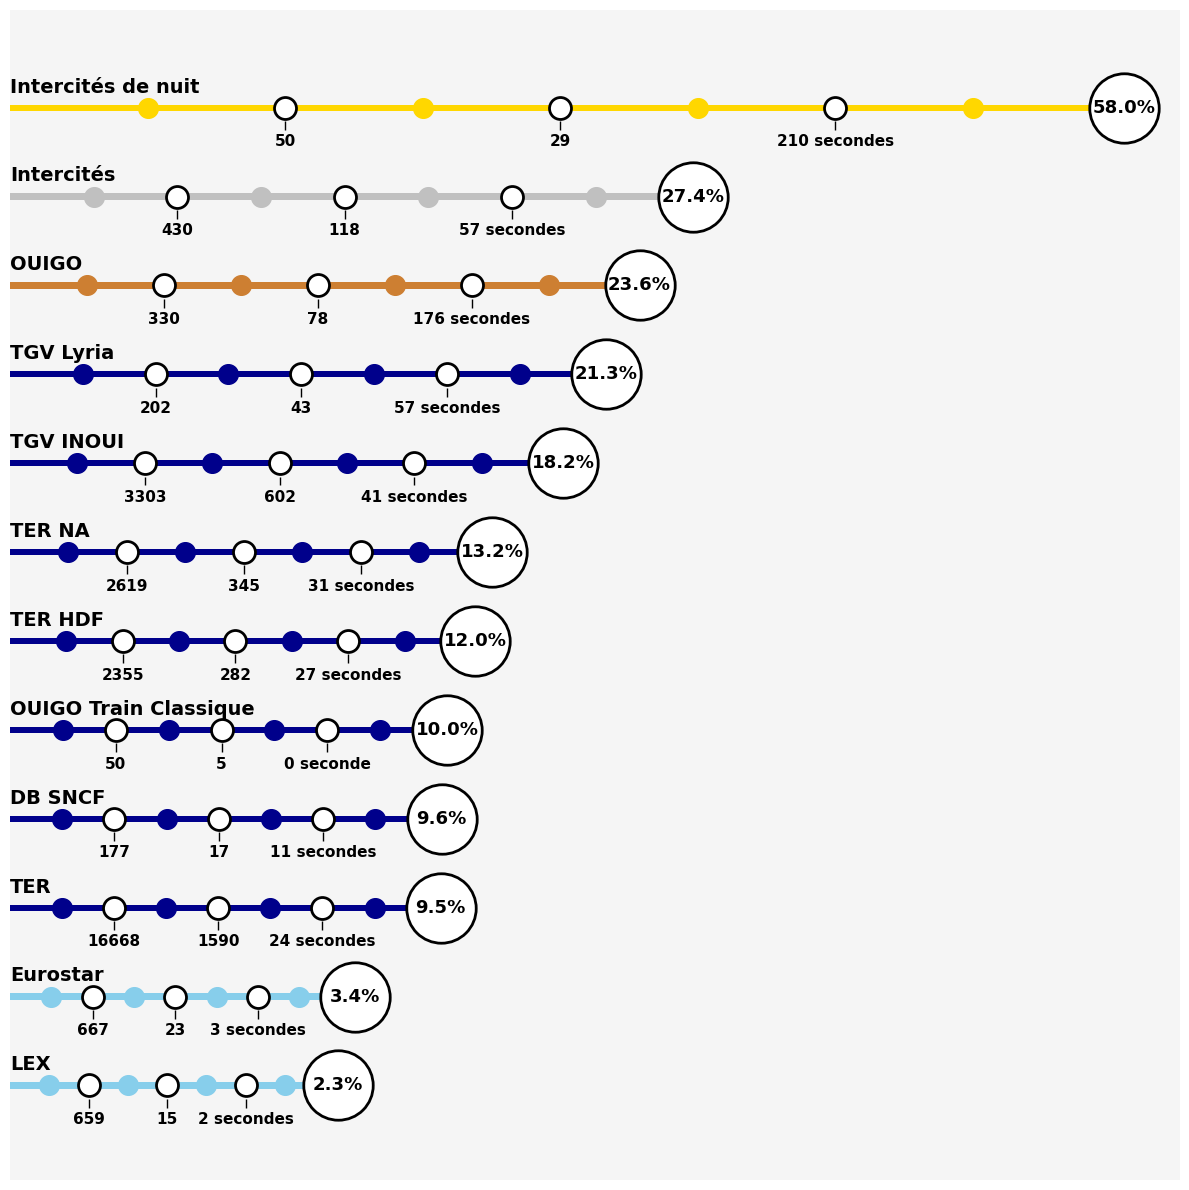

In [25]:
# Filtrage des éléments désirés directement avec Pandas
per_disrupted_vehicle_by_network_part1 = per_disrupted_vehicle_by_network

# Création d'une nouvelle Series avec les transformations souhaitées
transformation = (per_disrupted_vehicle_by_network_part1 + 20) * 0.1

# Configuration initiale de la figure
fig, ax = plt.subplots(figsize=(12, 12))
colors = ["skyblue", "skyblue", 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', "#CD7F32", "#C0C0C0", "#FFD700"]

# Création du diagramme à barres horizontales
bars = ax.barh(transformation.index, transformation, color=colors, height=0.07)

# Calcul des positions pour les marqueurs
x_positions = transformation + 0.1

# Ajout de marqueurs blancs
ax.scatter(x_positions, transformation.index, facecolors='white', edgecolors='black', linewidths=2, s=2500)

# Définition des intervalles pour les éléments décoratifs
intervals_white = [2/8, 4/8, 6/8]
intervals_black = [1/8, 3/8, 5/8, 7/8]

# Boucle pour ajouter du texte et des décorations supplémentaires sur les barres
for j, (bar, new_x) in enumerate(zip(bars, x_positions)):
    y = bar.get_y() + bar.get_height() / 2
    
    # Ajout de texte pour le pourcentage
    ax.text(new_x, y, f'{bar.get_width()/0.1 - 20:.1f}%', ha='center', va='center', fontsize=13, fontweight='bold')
    
    # Ajouter le nom du réseau au-dessus de chaque barre
    ax.text(0, y + bar.get_height() + 0.1, per_disrupted_vehicle_by_network_part1.index[j], fontsize=14, fontweight='bold')
    
    # Ajout de cercles et de lignes avec du texte
    for i, interval in enumerate(intervals_white):
        circle_x = bar.get_width() * interval
        # Ajouter cercle blanc et ligne
        ax.scatter(circle_x, y, facecolors='white', edgecolors='black', linewidths=2, s=250)
        ax.vlines(circle_x, y - 0.25, y - 0.15, colors='black', linewidth=1)
        # Ajouter texte spécifique sous la ligne
        current_info_value = info[i][transformation.index[j]]
        ax.text(circle_x, y - 0.3, f'{current_info_value}', ha='center', va='top', fontsize=11, fontweight='bold')
        
    # Ajout de cercles colorés pour les intervalles neutre
    for interval in intervals_black:
        circle_x = bar.get_width() * interval
        ax.scatter(circle_x, y, facecolors=colors[j], s=200)

# Configuration finale du graphique
ax.set_title('', fontsize=22)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_facecolor('whitesmoke')
sns.despine(left=True, bottom=True, ax=ax, offset=10, trim=True)
plt.tight_layout()
ax.set_ylim(bottom=ax.get_ylim()[0] -0.25, top=ax.get_ylim()[1] +0.5)
plt.savefig("Perturbation_ligne_global.png", dpi = 300)
plt.show()

# 

### ROUTES LES PLUS PERTURBEES ET CAUSES ASSOCIEES

In [26]:
# Nombre de trajet par route
vehicle_by_route = df_merge.groupby('route_name')['vehicle_id'].count()

# Nombre de perturbation par route
disruption_by_route = df_merge.groupby('route_name')['id_disruption'].count()

# Pourcentage de trajet perturbé par route
per_disruption_by_route = disruption_by_route/vehicle_by_route*100
per_disruption_by_route = per_disruption_by_route.replace([np.inf, -np.inf], 0).dropna()

In [27]:
# cela montre où les différents groupe de perturbation arrive --> pourrait servir pour comprendre ou il faut investir 
cause_group_by_route = df_merge.groupby(['group_delay', 'route_name'])['cause_delay'].count()

In [28]:
cause_by_route = df_merge.groupby(['cause_delay', 'route_name'])['cause_delay'].count()

# 

### ARRETS LES PLUS IMPACTES ET CAUSES ASSOCIEES

In [29]:
# Mettre en pourcentage de frequentation ? de vehicule qui passe ? 
most_impacted_stop = df_merge.groupby('name_stop')['id_disruption'].count().sort_values(ascending=False)

In [30]:
cause_group_by_stop = df_merge.groupby(['group_delay', 'name_stop'])['cause_delay'].count()

In [31]:
cause_by_stop = df_merge.groupby(['cause_delay', 'name_stop'])['cause_delay'].count()

# 

# 

#  ANALYSE TEMPORELLE DES PERTURBATION

### NOMBRE DE PERTURBATION AU FIL DE LA JOURNEE

In [32]:
start_time = datetime(2023, 1, 1, 0, 0) 
end_time = datetime(2023, 1, 2, 0, 0)  

ten_intervals = []
current_time = start_time
while current_time < end_time:
    ten_intervals.append(current_time.time())
    current_time += timedelta(minutes=10)
    
def disruption_across_day(df):
    start = [t.time() for t in df['disruption_start']]
    end = [t.time() for t in df['disruption_end']]
        
    disrupiton_by_ten = []

    for time in ten_intervals:
        nb_disruption = 0
        for i in range(len(start)):
            if time > start[i] and time < end[i]:
                nb_disruption += 1 
        disrupiton_by_ten.append(nb_disruption)
        
    return disrupiton_by_ten

disrupiton_by_ten = disruption_across_day(df_disruption_unique)

In [33]:
hours_intervals_name = []
count=0

for t in range(0,len(ten_intervals)):
    if count == 12 :
        hours_intervals_name.append(str(ten_intervals[t])[:5])
        count=0
    else :
        hours_intervals_name.append('')
    count+= 1

hours_intervals_name[0] = '00:00'
hours_intervals_name[-1] = '23:59'

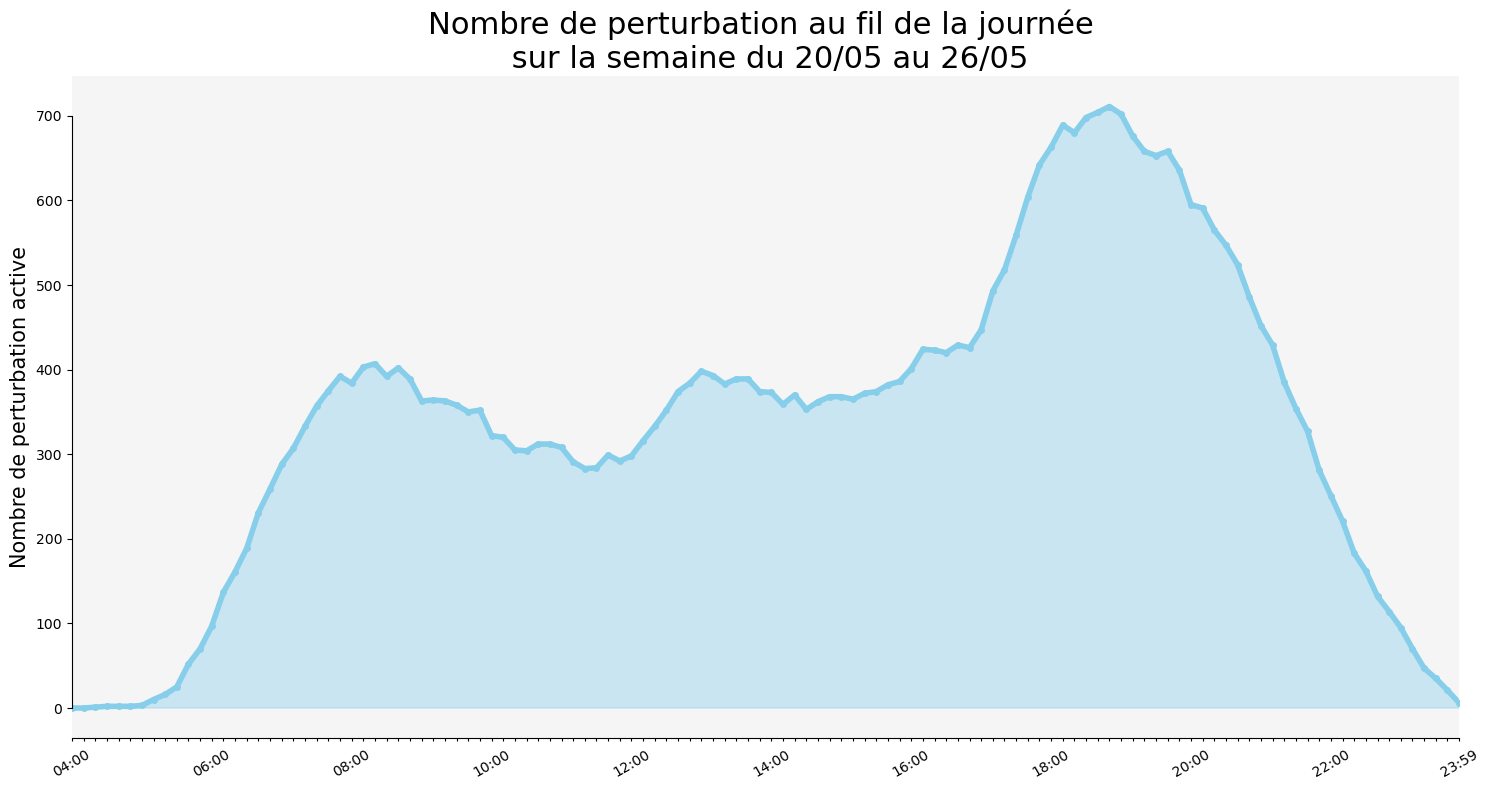

In [34]:
# voir si c'est possible de metre en valeur des valeurs bien choisis sur l'axe x (le petit trait)
plt.figure(figsize=(15, 8))

plt.plot(range(len(disrupiton_by_ten)), disrupiton_by_ten, c='skyblue', lw=4, marker='o', markersize=4)
plt.fill_between(range(len(disrupiton_by_ten)), disrupiton_by_ten, color='skyblue', alpha=0.4)

plt.title(f'Nombre de perturbation au fil de la journée \n sur la semaine du {week_start} au {week_end}', fontsize=22)
plt.ylabel('Nombre de perturbation active', fontsize=15)
plt.xticks(range(len(disrupiton_by_ten)), hours_intervals_name, rotation=30, fontsize=10)
plt.tick_params(axis='x', which='both', length=2, pad=5)
plt.xlim(24, len(disrupiton_by_ten) - 1)

plt.gca().set_facecolor('whitesmoke')

plt.tight_layout()
sns.despine(trim=True)

plt.show()

# 

### NOMBRE DE PERTURBATIONS PAR TYPE DE PERTURBATION AU FIL DE LA JOURNEE

In [35]:
df_disruption_incivilite = df_disruption_unique[df_disruption_unique['cause_delay'].isin(incivilite)]
disrupiton_by_ten_incivilite = disruption_across_day(df_disruption_incivilite)

df_disruption_problemes_techniques = df_disruption_unique[df_disruption_unique['cause_delay'].isin(problemes_techniques)]
disruption_by_ten_problemes_techniques = disruption_across_day(df_disruption_problemes_techniques)

df_disruption_conditions_operationnelles = df_disruption_unique[df_disruption_unique['cause_delay'].isin(conditions_operationnelles)]
disruption_by_ten_conditions_operationnelles = disruption_across_day(df_disruption_conditions_operationnelles)

df_disruption_conditions_externes = df_disruption_unique[df_disruption_unique['cause_delay'].isin(conditions_externes)]
disruption_by_ten_conditions_externes = disruption_across_day(df_disruption_conditions_externes)

df_disruption_assistance_passagers = df_disruption_unique[df_disruption_unique['cause_delay'].isin(assistance_passagers)]
disruption_by_ten_assistance_passagers = disruption_across_day(df_disruption_assistance_passagers)

df_disruption_non_specifie = df_disruption_unique[df_disruption_unique['cause_delay'] == 'Non connu' ]
disruption_by_ten_non_specifie = disruption_across_day(df_disruption_non_specifie)

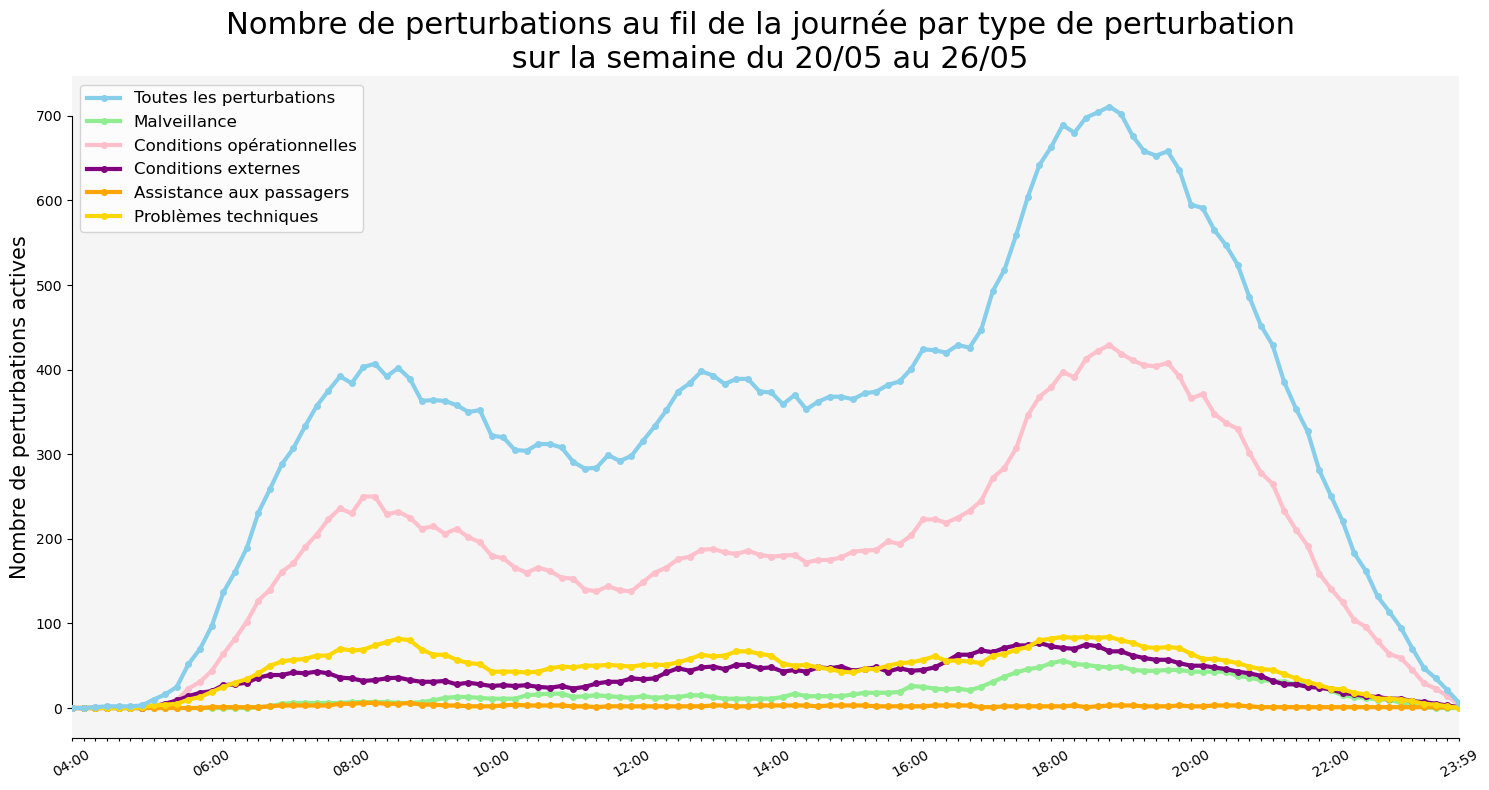

In [36]:
plt.figure(figsize=(15, 8))

plt.plot(range(len(disrupiton_by_ten)), disrupiton_by_ten, c='skyblue', lw=3, marker='o', markersize=4, label='Toutes les perturbations', zorder = 10)
plt.plot(range(len(disrupiton_by_ten_incivilite)), disrupiton_by_ten_incivilite, c='lightgreen', lw=3, marker='o', markersize=4, label='Malveillance')
plt.plot(range(len(disruption_by_ten_conditions_operationnelles)), disruption_by_ten_conditions_operationnelles, c='pink', lw=3, marker='o', markersize=4, label='Conditions opérationnelles')
plt.plot(range(len(disruption_by_ten_conditions_externes)), disruption_by_ten_conditions_externes, c='purple', lw=3, marker='o', markersize=4, label='Conditions externes')
plt.plot(range(len(disruption_by_ten_assistance_passagers)), disruption_by_ten_assistance_passagers, c='orange', lw=3, marker='o', markersize=4, label='Assistance aux passagers')
plt.plot(range(len(disruption_by_ten_problemes_techniques)), disruption_by_ten_problemes_techniques, c='gold', lw=3, marker='o', markersize=4, label='Problèmes techniques')

plt.title(f'Nombre de perturbations au fil de la journée par type de perturbation \n sur la semaine du {week_start} au {week_end}', fontsize=22)
plt.ylabel('Nombre de perturbations actives', fontsize=15)
plt.xticks(range(len(disrupiton_by_ten)), hours_intervals_name, rotation=30, fontsize=10)
plt.tick_params(axis='x', which='both', length=2, pad=5)
plt.xlim(24, len(disrupiton_by_ten) - 1)

plt.gca().set_facecolor('whitesmoke')

plt.legend(fontsize=12)
plt.tight_layout()
sns.despine(trim=True)

plt.show()

# 

### CAUSES DES PERTURBATIONS SUR LA SEMAINE ET RETARD CAUSE PAR CES CAUSES

In [37]:
cause_delay_count = df_disruption_unique.groupby(['group_delay', 'cause_delay'])['cause_delay'].count()
# En faire un tableau en rajoutant les totaux


cause_delay_count_group_daily = df_disruption_unique.groupby(['data_date', 'group_delay'])['cause_delay'].count()
# En faire un tableau en rajoutant les totaux

In [38]:
delay_by_cause = df_disruption_unique.groupby(['group_delay', 'cause_delay'])['arrival_delay'].sum()
# En faire un tableau en rajoutant les totaux

In [39]:
delay_by_cause_group_daily = df_disruption_unique.groupby(['data_date','group_delay'])['arrival_delay'].sum()
# En faire un tableau en rajoutant les totaux

# 

# 

# SAUVEGARDE DES RESULTATS

In [192]:
total_delay_daily = [total_delay_daily.to_dict()]
mean_time_disruption_minutes_daily = [mean_time_disruption_minutes_daily.to_dict()]
nb_disruption_daily = [nb_disruption_daily.to_dict()]
nb_vehicle_journeys_daily = [nb_vehicle_journeys_daily.to_dict()]
per_disrupted_daily = [per_disrupted_daily.to_dict()]
vehicle_by_network = [vehicle_by_network.to_dict()]
disrupted_vehicle_by_network= [disrupted_vehicle_by_network.to_dict()]
per_disrupted_vehicle_by_network = [per_disrupted_vehicle_by_network.to_dict()]
avg_delay_by_network = [avg_delay_by_network.to_dict()]
vehicle_by_route = [vehicle_by_route.to_dict()]
disruption_by_route = [disruption_by_route.to_dict()]
per_disruption_by_route = [per_disruption_by_route.to_dict()]
cause_group_by_route = [cause_group_by_route.to_dict()]
cause_by_route = [cause_by_route.to_dict()]
most_impacted_stop = [most_impacted_stop.to_dict()]
cause_group_by_stop = [cause_group_by_stop.to_dict()]
cause_by_stop = [cause_by_stop.to_dict()]
cause_delay_count = [cause_delay_count.to_dict()]
delay_by_cause = [delay_by_cause.to_dict()]
disrupiton_by_ten = [disrupiton_by_ten]
disrupiton_by_ten_incivilite = [disrupiton_by_ten_incivilite]
disruption_by_ten_problemes_techniques = [disruption_by_ten_problemes_techniques]
disruption_by_ten_conditions_operationnelles = [disruption_by_ten_conditions_operationnelles]
disruption_by_ten_conditions_externes = [disruption_by_ten_conditions_externes]
disruption_by_ten_assistance_passagers = [disruption_by_ten_assistance_passagers]
disruption_by_ten_non_specifie = [disruption_by_ten_non_specifie]

In [193]:
dict_temporelle = {'nb_disruption':nb_disruption,
                   'nb_vehicle_journeys':nb_vehicle_journeys,
                   'per_disrupted':per_disrupted,
                   'nb_disruption_daily':nb_disruption_daily,
                   'nb_vehicle_journeys_daily':nb_vehicle_journeys_daily,
                   'per_disrupted_daily': per_disrupted_daily,
                   'mean_time_disruption_minutes':mean_time_disruption_minutes,
                   'mean_time_disruption_minutes_daily': mean_time_disruption_minutes_daily,
                   'total_delay':total_delay,
                   'total_delay_daily': total_delay_daily,
                   'mean_delay_by_disruption':total_delay/nb_disruption*60,
                   'vehicle_by_network': vehicle_by_network,
                   'disrupted_vehicle_by_network':disrupted_vehicle_by_network,
                   'per_disrupted_vehicle_by_network':per_disrupted_vehicle_by_network,
                   'avg_delay_by_network':avg_delay_by_network,
                   'vehicle_by_route':vehicle_by_route,
                   'disruption_by_route':disruption_by_route,
                   'per_disruption_by_route':per_disruption_by_route,
                   'cause_group_by_route':cause_group_by_route,
                   'cause_by_route':cause_by_route,
                   'most_impacted_stop':most_impacted_stop,
                   'cause_group_by_stop':cause_group_by_stop,
                   'cause_by_stop':cause_by_stop,
                   'cause_delay_count':cause_delay_count,
                   'delay_by_cause':delay_by_cause,
                   'disrupiton_by_ten': disrupiton_by_ten,
                   'disrupiton_by_ten_incivilite': disrupiton_by_ten_incivilite,
                   'disruption_by_ten_problemes_techniques':disruption_by_ten_problemes_techniques,
                   'disruption_by_ten_conditions_operationnelles':disruption_by_ten_conditions_operationnelles,
                   'disruption_by_ten_conditions_externes':disruption_by_ten_conditions_externes,
                   'disruption_by_ten_assistance_passagers':disruption_by_ten_assistance_passagers,
                   'disruption_by_ten_non_specifie':disruption_by_ten_non_specifie,
                   'data_date':week_start                   
}

In [194]:
df_temporelle = pd.DataFrame(dict_temporelle)
df_temporelle.to_csv('Resultats_rapport.csv', mode='a', header=False, index=False)